## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os

import librosa
import librosa.display

import torch
from torch import nn
from torchvision import models, transforms, datasets

from time import time
from tqdm import tqdm

from PIL import Image

## Defining Parameters

In [2]:
seed = 12
np.random.seed(seed)

path = "../input/gtzan-dataset-music-genre-classification/"

path_audio_files = path + "Data/genres_original/"

path_imgs = "./mel_spectrogram_imgs/"

batch_size = 32

hop_length = 512

n_fft = 2048

device = 'cuda' if torch.cuda.is_available() else 'cpu'

genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}
class_dict = {0: "blues", 1: "classical", 2: "country", 3: "disco", 4: "hiphop", 
                  5: "jazz", 6: "metal", 7: "pop", 8: "reggae", 9: "rock"}


## Transforming Audio Files into Mel Spectograms and Saving the Images

In [3]:
print("Transforming the Audio Files into Mel Spectrograms:")

mel_spectogram_data = {}
for genre in genre_dict.keys():
    print("\t",genre)
    
    mel_spectogram_data[genre] = []

    for name in glob.glob(path_audio_files + genre + "/*"):
        
        if(name != "../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav"):
        
            data,sampling_rate = librosa.load(name)

            mel_spec = librosa.feature.melspectrogram(y = data.ravel(), sr=sampling_rate,hop_length = hop_length)
            mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
#             mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            mel_spectogram_data[genre].append(mel_spec_db)
            

print("Saving the Mel Spectrogram Images:")
            
os.mkdir(path_imgs)
for genre in genre_dict.keys():
    print("\t",genre)
    try:
        os.mkdir(path_imgs + genre)
    except:
        pass
    
    for i in range(len(mel_spectogram_data[genre])):

        fig, ax = plt.subplots(1, figsize=(12,8))

#         img = librosa.display.specshow(mel_spectogram_data[genre][i], sr = sampling_rate, hop_length = hop_length,cmap = 'cool',ax=ax)
        img = librosa.display.specshow(mel_spectogram_data[genre][i], sr = sampling_rate, hop_length = hop_length,ax=ax)
# 
        fig.savefig(path_imgs + genre + "/" + genre + "_" + str(i) + ".png")
        
        plt.close()

In [4]:
import gc
gc.collect()

## Load and Transform the Data

In [5]:
%%time

# Define Tranforms
train_transforms = transforms.Compose([
    #transforms.Resize(224),
    transforms.ToTensor(),
    
    transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])
])

test_transforms = transforms.Compose([
    #transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])
])

# Load the data
train_dataset = datasets.ImageFolder(path_imgs, transform = train_transforms)
val_dataset = datasets.ImageFolder(path_imgs, transform = test_transforms)
test_dataset = datasets.ImageFolder(path_imgs, transform = test_transforms)


torch.manual_seed(1)
num_train_samples = len(train_dataset)
#num_train_samples = 20000

# Permute the data
indices = torch.randperm(num_train_samples)

# Split the data into Train and Validation
train_testval_split = 0.2
train_split = int(num_train_samples * train_testval_split)
val_split = int(train_split * 0.5)

train_subset = torch.utils.data.Subset(train_dataset, indices[train_split:])
val_subset = torch.utils.data.Subset(val_dataset, indices[val_split:train_split])
test_subset = torch.utils.data.Subset(test_dataset, indices[:val_split])


print(f"Length of Train:{len(train_subset)}; Length of Val:{len(val_subset)}; Length of Test:{len(test_subset)}")



# Make DataLoaders 
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset, 
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False
)

# Classes
classes = train_dataloader.dataset.dataset.classes

In [6]:
def mean_std(loader):
    images, lebels = next(iter(loader))
    # shape of images = [b,c,w,h]
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std

mean, std = mean_std(train_dataloader)
print("mean and std: \n", mean, std)

## ResNet18 - Transfer Learning

In [7]:
# Load a Pretrained Model
resnet = models.resnet18(pretrained=True)

# Fix the trainable parameters
for parameter in resnet.parameters():
    parameter.requires_grad = False
    
    
# Number of Input Features in the Last Fully Connected Layer
in_features = resnet.fc.in_features

# Replacing the Last Fully Connected Layer
fc = nn.Linear(in_features=in_features, out_features=len(classes))
resnet.fc = fc


# Updating the Weights and Bias of the last layer
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# Define the Loss and Optimizer Functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

## Training the Model

In [8]:
def train(model, name, criterion, optimizer, train_dataloader,test_dataloader,print_every,num_epoch):
    
    steps = 0
    train_losses, val_losses = [], []
    
    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()
                        
                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()
                
                
                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint{name}_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

In [9]:
# VGG16

In [10]:
print_every = 25
num_epoch = 50

resnet, train_losses, val_losses = train(
    model=resnet,
    name="resnet",
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    print_every=print_every,
    num_epoch=num_epoch
)


plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [11]:
torch.save(resnet, f'resnet_best')


In [12]:
# Load a pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)


# Freeze all parameters in the model
for parameter in vgg16.parameters():
    parameter.requires_grad = False

    
num_classes = len(classes) # Ensure 'classes' contains your class labels
in_features = vgg16.classifier[6].in_features # Get the number of input features to the last layer
vgg16.classifier[6] = nn.Linear(in_features, num_classes)

# Collect parameters that require gradients (just the parameters of the last layer you've modified)
params_to_update = [param for param in vgg16.parameters() if param.requires_grad]

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

In [13]:

vgg16, train_losses, val_losses = train(
    model=vgg16,
    name="vgg16",
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    print_every=print_every,
    num_epoch=num_epoch
)


plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Testing

In [14]:
y_test = []
y_pred = []
for img, label in test_subset:
    img = torch.Tensor(img)
    img = img.to(device)
    resnet.eval()
    prediction = resnet(img[None])
    
    final_pred = classes[torch.max(prediction, dim=1)[1]]
    
    #print(label, genre_dict[final_pred])
    
    y_test.append(label)
    y_pred.append(genre_dict[final_pred])


In [15]:
print("Accuracy:",(100*(np.array(y_test) == np.array(y_pred)).sum()/len(y_test)))

In [16]:
y_test = []
y_pred = []
for img, label in test_subset:
    img = torch.Tensor(img)
    img = img.to(device)
    vgg16.eval()
    prediction = vgg16(img[None])
    
    final_pred = classes[torch.max(prediction, dim=1)[1]]
    
    #print(label, genre_dict[final_pred])
    
    y_test.append(label)
    y_pred.append(genre_dict[final_pred])


In [17]:
print("Accuracy:",(100*(np.array(y_test) == np.array(y_pred)).sum()/len(y_test)))

This seems to be a good baseline model for this task.

I'll be trying to improve the performance by including more preprocessed features which I have detailed in [this notebook](https://www.kaggle.com/code/nippani/preprocessing-audio-data-gtzan).

If you liked this notebook, please upvote.

Also, do let me know if there are any corrections/additions needed.

## Demo

In [18]:
!pip install gdown

In [19]:
!gdown 1VWMGE7ErtCjfEbszv5skVHeTGCxuv1fx 

In [20]:
!unzip weights.zip

In [21]:
!ls weights

In [22]:
!gdown 153yGfBOrfh_5omVsV4NLRgQ0jY4oLJQL

Downloading...
From (original): https://drive.google.com/uc?id=153yGfBOrfh_5omVsV4NLRgQ0jY4oLJQL
From (redirected): https://drive.google.com/uc?id=153yGfBOrfh_5omVsV4NLRgQ0jY4oLJQL&confirm=t&uuid=4e0f719b-3ffe-46df-836e-7a0fe458b54e
To: /kaggle/working/resnet_best
100%|██████████████████████████████████████| 44.8M/44.8M [00:00<00:00, 98.0MB/s]


In [23]:
resnet = torch.load("resnet_best")

In [24]:
def create_mel_spectrogram_image(audio_file_path, image_save_path, sampling_rate=22050, hop_length=512):
    # Load the audio file
    # In the GTZAN dataset, each song is 30 s long, with a 22,050 Hz sample rate, 
    # mono mode, AU file format, and 16-bit audio files
    data, sr = librosa.load(audio_file_path, sr=sampling_rate)

    # Generate mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, hop_length=hop_length)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
#     mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Plot and save the mel spectrogram as an image
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hop_length)
    plt.axis('off')  # Optional: Remove axes for a cleaner image
    plt.savefig(image_save_path, bbox_inches='tight', pad_inches=0)
    plt.close()



In [25]:
def classify_audio(image_path, model, num_classes=10):    
    img = Image.open(image_path).convert('RGB')
    img_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])
    ])
    
    img_normalized = img_transformer(img)
    img_normalized = img_normalized.unsqueeze_(0)
    img_normalized = img_normalized.to(device)

    # Predict with both models
    with torch.no_grad():
        model.eval()
        prediction = model(img_normalized)

    # Convert predictions to probabilities
    probs = nn.functional.softmax(prediction, dim=1)

    # Get the top 3 predictions and their indices
    top_probs, top_indices = torch.topk(probs, 10)

    # Convert the top probabilities to percentages
    top_percentages = [round(prob.item() * 100, 2) for prob in top_probs[0]]
    
    # Convert indices to class names
    top_genres = [class_dict[index.item()] for index in top_indices[0]]

    # Combine class names with their corresponding percentages
    predictions = list(zip(top_genres, top_percentages))

    return predictions

    
#     # Convert predictions to probabilities
#     probs = nn.functional.softmax(prediction, dim=1)
#     return probs
    
    # Get the predicted classes
#     vgg16_predicted_class = torch.argmax(probs)
#     resnet18_predicted_class = torch.argmax(resnet18_probs)
    
#     return predicted_class.item()

In [37]:
!gdown 16OzhpXiXg9fdk4meG0Umevoa3kHSU6GA -O audio.mp3

Downloading...
From: https://drive.google.com/uc?id=16OzhpXiXg9fdk4meG0Umevoa3kHSU6GA
To: /kaggle/working/audio.mp3
100%|███████████████████████████████████████| 9.55M/9.55M [00:00<00:00, 262MB/s]


In [38]:
audio_file_path = 'audio.mp3'
image_save_path = 'input.png'
create_mel_spectrogram_image(audio_file_path, image_save_path)

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [39]:
classify_audio("input.png", resnet)

[('country', 91.03),
 ('disco', 4.9),
 ('pop', 2.54),
 ('blues', 0.71),
 ('rock', 0.45),
 ('hiphop', 0.15),
 ('metal', 0.14),
 ('reggae', 0.04),
 ('jazz', 0.02),
 ('classical', 0.01)]

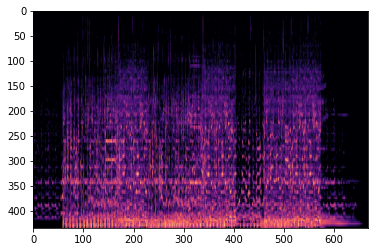

In [29]:
image = Image.open('input.png')

# Display the image using plt.imshow
plt.imshow(image)
plt.show()
